In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from skimage.metrics import structural_similarity as ssim
from methods import BayesianTomography, MGLoss, RMSELoss

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0 
plt.rcParams['ytick.major.width'] = 1.0 
plt.rcParams['font.size'] = 9  
plt.rcParams['axes.linewidth'] = 1.0 

torch.manual_seed(5)
np.random.seed(5)
random.seed(5)
D_DIM = 12  # detector dimensition
F_DIM = 64  # reconstructed image dimenstion
NOISE_RATE = 0.125 
KERNEL = "NS"  # switch between nonstationary(NS) and stationary(SE)
norm = 0.7 # pixel distance ratio
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# d = Rf
R = np.load(f"R_{D_DIM}_{F_DIM}.npy")
f = np.load(f"f_{F_DIM}.npy")[:, ::-1] 
d = R.dot(f.flatten())
ls_image = np.load(f"ls_image_{F_DIM}.npy")
model = BayesianTomography(R=R, d=d, ls_img=ls_image, device=device, noise_rate=NOISE_RATE, kernel=KERNEL, norm=norm)
train_y_img = torch.tensor(f.flatten())

model = model.to(device, dtype=torch.float32)
train_y_img = train_y_img.to(device, dtype=torch.float32)


loss_function2 = RMSELoss()
loss_function = MGLoss()


In [5]:
optimizer = torch.optim.Adam([
    {'params': model.parameters()},

], lr=0.07)

model.train()
training_iter = 20
prev_loss = 100000000
prev_loss_img = 1000000000
for i in range(training_iter):
    optimizer.zero_grad()
    model()
    if torch.isnan(model.d_mu).any():
        print("BREAK!!")
        break
    loss = loss_function(model)
    loss_img = loss_function2(model.f_mu, train_y_img)
    print(f"loss_img:{loss_img.item():.3f},minus_evidence:{loss.item():.0f}")
    if prev_loss > loss and loss > 0:
        print("updated")
        prev_model = model
        prev_loss = loss
        prev_loss_img = loss_img
    loss.backward(retain_graph=True)
    optimizer.step()
for n, p in prev_model.named_parameters():
    print(n, p)


loss_img:0.186,minus_evidence:757
updated
loss_img:0.184,minus_evidence:739
updated
loss_img:0.183,minus_evidence:719
updated
loss_img:0.182,minus_evidence:697
updated
loss_img:0.180,minus_evidence:674
updated
loss_img:0.180,minus_evidence:648
updated
loss_img:0.179,minus_evidence:619
updated
loss_img:0.179,minus_evidence:589
updated
loss_img:0.179,minus_evidence:557
updated
loss_img:0.179,minus_evidence:526
updated
loss_img:0.179,minus_evidence:500
updated
loss_img:0.180,minus_evidence:497
updated
loss_img:0.181,minus_evidence:541
loss_img:0.180,minus_evidence:541
loss_img:0.179,minus_evidence:514
loss_img:0.178,minus_evidence:494
updated
loss_img:0.177,minus_evidence:491
updated
loss_img:0.178,minus_evidence:491
updated
loss_img:0.178,minus_evidence:495
loss_img:0.179,minus_evidence:500
le Parameter containing:
tensor(-0.0348, device='cuda:0', requires_grad=True)
lc Parameter containing:
tensor(1.3313, device='cuda:0', requires_grad=True)
lm Parameter containing:
tensor(-0.2522, devi

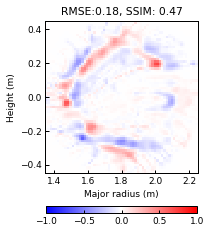

In [6]:
out_f = prev_model.f_mu.detach().cpu().numpy().reshape(*f.shape)
rmse_loss = prev_loss_img.detach().cpu().numpy()
ssim_loss = ssim(out_f, f,
                 data_range=f.max() - f.min())
plt.axes().set_aspect('equal')
plt.title(f"RMSE:{rmse_loss:.2f}, SSIM: {ssim_loss:.2f}")
y = np.linspace(-0.45, 0.45, F_DIM)
x = np.linspace(1.35, 2.25, F_DIM)
X, Y = np.meshgrid(x, y)
plt.ylabel("Height (m)")
plt.xlabel("Major radius (m)")
plt.pcolor(X, Y, out_f, cmap="bwr", vmax=1., vmin=-1.)
plt.colorbar(orientation="horizontal", shrink=0.45)
# plt.savefig(f"{KERNEL}_{D_DIM}_{NOISE_RATE:.2f}.png")

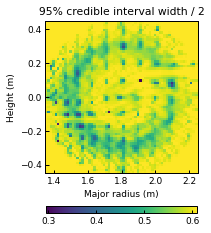

In [7]:
post_cov = prev_model.post_cov.detach().cpu().numpy()
cov = np.sqrt(np.diag(post_cov).reshape(*f.shape)) * 1.96
plt.axes().set_aspect('equal')
plt.title("95% credible interval width / 2")
plt.ylabel("Height (m)")
plt.xlabel("Major radius (m)")
plt.pcolor(X, Y, cov)
plt.colorbar(orientation="horizontal", shrink=0.45)
# plt.savefig(f"{KERNEL}_{D_DIM}_sigma.png")

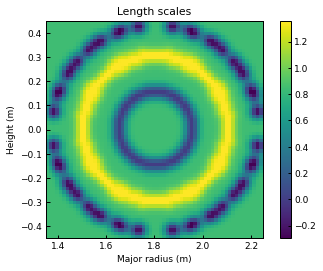

In [8]:
if KERNEL == 'NS':
	plt.axes().set_aspect('equal')
	plt.title("Length scales")
	l_all = prev_model.l_all.detach().cpu().numpy().reshape(*f.shape)
	plt.pcolor(X, Y, l_all)
	plt.colorbar()
	plt.ylabel("Height (m)")
	plt.xlabel("Major radius (m)")
	# plt.savefig("optimized_l.png")